# PermRowCol experimental results

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from multiprocessing import Pool

from pyzx import cnot_mapper, architecture # Note that this is the local pyzx package from this repository/fork, not the one installed through pip or other means.

First, we specify some code to read the dataset of CNOT circuits that was used in [ArXiv 1904.00633](https://arxiv.org/pdf/1904.00633.pdf). Since the original paper only used 20 circuits per test case (number of qubits, number of original CNOTs), we generated 80 more circuits that are now available on this GitHub repository in the folder circuits/steiner/

In [2]:
def read_circuit(source):
    if not os.path.exists(source):
        print("File {} does not exist".format(source))
        return
    return cnot_mapper.CNOT_tracker.from_qasm_file(source, parities_as_columns=True)

def read_circuits(n_qubits):
    source_folder = "../circuits/steiner/"
    circuits = []
    sources = []
    subfolder = os.path.join(source_folder, str(n_qubits)+"qubits/")

    for folder in os.listdir(subfolder):
        folder = os.path.join(subfolder, folder)
        if os.path.isdir(folder):
            for file in os.listdir(folder):
                if file.endswith(".qasm"):
                    src = os.path.join(folder, file)
                    circuit = read_circuit(src)
                    circuits.append(circuit)
                    sources.append(src)
    return circuits, sources

Then we run our experiment with the algorithms as they are.

In [14]:
def multiprocess_experiments(mode, circuits, arch):
    pool = Pool(processes=os.cpu_count())
    n_circuits = len(circuits)
    inputs = zip([mode]*n_circuits, 
                 [cnot_mapper.Mat2(np.copy(c.matrix.data)) for c in circuits], 
                 [arch]*n_circuits,
                 [True]*n_circuits
                )
    new_circuits =  pool.starmap(cnot_mapper.gauss_return_circuit, inputs)
    return [c.count_cnots() for c in new_circuits]

def run_steiner_gauss(circuits, arch):
    return multiprocess_experiments(cnot_mapper.STEINER_MODE, circuits, arch)

def run_rowcol(circuits, arch):
    return multiprocess_experiments(cnot_mapper.ROWCOL_MODE, circuits, arch)

def run_perm_rowcol(circuits, arch):
    return multiprocess_experiments(cnot_mapper.PERMROWCOL_MODE, circuits, arch)

# Reverse traversal parameters
RT_parameters = {
    "max_iter" : 15
}

Astar_parameters = {
    "choiceWidth": 4,
    "parities_as_columns": True,
    "max_size": 10
}

def run_reverse_traversal(circuits, arch): 
    pool = Pool(os.cpu_count())
    n_circuits = len(circuits)
    inputs = zip([cnot_mapper.Mat2(np.copy(c.matrix.data)) for c in circuits], [arch]*n_circuits, [RT_parameters["max_iter"]]*n_circuits)
    new_circuits = pool.starmap(cnot_mapper.reverse_traversal, inputs)
    return [c.count_cnots() for c,i,o in new_circuits]

def run_A_permrowcol(circuits, arch):
    pool = Pool(os.cpu_count())
    n_circuits = len(circuits)
    inputs = zip([cnot_mapper.Mat2(np.copy(c.matrix.data)) for c in circuits], [arch]*n_circuits, 
                 [Astar_parameters["choiceWidth"]]*n_circuits,
                [Astar_parameters["max_size"]]*n_circuits,
                [Astar_parameters["parities_as_columns"]]*n_circuits)
    new_circuits = pool.starmap(cnot_mapper.A_permrowcol, inputs)
    return [c.count_cnots() for p,c in new_circuits]


def run_Astart_reverse_traversal(circuits, arch): 
    pool = Pool(os.cpu_count())    
    n_circuits = len(circuits)
    inputs = zip([cnot_mapper.Mat2(np.copy(c.matrix.data)) for c in circuits], [arch]*n_circuits, [RT_parameters["max_iter"]]*n_circuits,  [Astar_parameters]*n_circuits)
    new_circuits = pool.starmap(cnot_mapper.reverse_traversal, inputs)
    return [c.count_cnots() for c,i,o in new_circuits]

In [4]:
def run_experiment(arch, method):
    n_qubits = arch.n_qubits
    og_circuits, srcs = read_circuits(n_qubits)
    results = pd.DataFrame()

    results["Original"] = np.array([int(src.split("/")[-2]) for src in srcs])
    results["#Qubits"] = np.array([n_qubits]*len(og_circuits))
    results["Architecture"] = np.array([arch.name]*len(og_circuits))
    
    for m, func in method.items():
        print("Running", m)
        results[(m, "count")] = np.array(func(og_circuits, arch))
        results[(m, "overhead (%)")] = (results[(m, "count")]/results["Original"] - 1)*100
        tmp = results.groupby(["Original", "Architecture", "#Qubits"]).mean()
        tmp.columns = pd.MultiIndex.from_tuples(tmp.columns.tolist()) 
        tmp.to_csv("tmp/"+m+arch.name+" results.csv")

    results = results.groupby(["Original", "Architecture", "#Qubits"]).mean()

    results.columns = pd.MultiIndex.from_tuples(results.columns.tolist()) 
    results.to_csv("tmp/"+arch.name+" results.csv")
    return results

In [16]:
archs = [
    architecture.create_architecture(architecture.SQUARE, n_qubits=9),
    architecture.create_architecture(architecture.SQUARE, n_qubits=16),
    architecture.create_architecture(architecture.RIGETTI_16Q_ASPEN),
    architecture.create_architecture(architecture.IBM_QX5),
    architecture.create_architecture(architecture.IBM_Q20_TOKYO)
]

method = {
    "SteinerGauss": run_steiner_gauss,
    "RowCol": run_rowcol,
    "PermRowCol without RT": run_perm_rowcol,
    "PermRowCol with RT": run_reverse_traversal
}

results = pd.concat([run_experiment(arch, method) for arch in archs])
results.to_csv("PermRowCol results.csv")

Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with RT
Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with RT
Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with RT
Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with RT
Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with RT


In [17]:
results

SteinerGauss               RowCol  \
                                          count overhead (%)   count   
Original Architecture      #Qubits                                     
3        9q-square         9              11.96   298.666667   12.26   
5        9q-square         9              18.23   264.600000   18.74   
10       9q-square         9              33.69   236.900000   32.67   
20       9q-square         9              49.05   145.250000   46.82   
30       9q-square         9              55.58    85.266667   53.52   
4        16q-square        16             29.90   647.500000   29.02   
8        16q-square        16             55.14   589.250000   55.70   
16       16q-square        16             97.85   511.562500   92.24   
32       16q-square        16            151.54   373.562500  141.57   
64       16q-square        16            189.09   195.453125  175.74   
128      16q-square        16            200.40    56.562500  189.32   
256      16q-square        16            201.95   -21.113281  190.83   
4        rigetti_16q_aspen 16             55.59  1289.750000   50.00   
8        rigetti_16q_aspen 16            100.85  1160.625000   88.78   
16       rigetti_16q_aspen 16            155.25   870.312500  138.99   
32       rigetti_16q_aspen 16            223.03   596.968750  199.41   
64       rigetti_16q_aspen 16            259.77   305.890625  240.51   
128      rigetti_16q_aspen 16            270.64   111.437500  252.33   
256      rigetti_16q_aspen 16            270.07     5.496094  255.06   
4        ibm_qx5           16             37.87   846.750000   37.96   
8        ibm_qx5           16             72.34   804.250000   71.43   
16       ibm_qx5           16            121.33   658.312500  115.63   
32       ibm_qx5           16            184.57   476.781250  174.74   
64       ibm_qx5           16            227.48   255.437500  218.93   
128      ibm_qx5           16            242.96    89.812500  238.07   
256      ibm_qx5           16            244.43    -4.519531  238.25   
4        ibm_q20_tokyo     20             24.04   501.000000   23.14   
8        ibm_q20_tokyo     20             50.58   532.250000   49.09   
16       ibm_q20_tokyo     20             99.70   523.125000   94.17   
32       ibm_q20_tokyo     20            177.58   454.937500  163.22   
64       ibm_q20_tokyo     20            249.51   289.859375  235.23   
128      ibm_q20_tokyo     20            281.34   119.796875  269.25   
256      ibm_q20_tokyo     20            288.01    12.503906  273.23   

                                                PermRowCol without RT  \
                                   overhead (%)                 count   
Original Architecture      #Qubits                                      
3        9q-square         9         308.666667                 12.17   
5        9q-square         9         274.800000                 16.33   
10       9q-square         9         226.700000                 28.17   
20       9q-square         9         134.100000                 40.01   
30       9q-square         9          78.400000                 45.75   
4        16q-square        16        625.500000                 33.86   
8        16q-square        16        596.250000                 58.49   
16       16q-square        16        476.500000                 87.95   
32       16q-square        16        342.406250                133.99   
64       16q-square        16        174.593750                184.84   
128      16q-square        16         47.906250                204.89   
256      16q-square        16        -25.457031                205.16   
4        rigetti_16q_aspen 16       1150.000000                 51.77   
8        rigetti_16q_aspen 16       1009.750000                 90.12   
16       rigetti_16q_aspen 16        768.687500                132.58   
32       rigetti_16q_aspen 16        523.156250                174.21   
64       rigetti_16q_aspen 16        275.796875        

In [18]:
archs = [
    architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=5),
    architecture.create_architecture(architecture.LINE, n_qubits=5),
    architecture.create_architecture(architecture.IBM_QX2),
    architecture.create_architecture(architecture.IBM_QX4)
]
method = {
    "SteinerGauss": run_steiner_gauss,
    "RowCol": run_rowcol,
    "PermRowCol without RT": run_perm_rowcol,
    "PermRowCol with RT": run_reverse_traversal,
    "PermRowCol with A*": run_A_permrowcol,
    "PermRowCol with RT and A*": run_Astart_reverse_traversal
}

results = pd.concat([run_experiment(arch, method) for arch in archs])
results.to_csv("A* PermRowCol results.csv")

Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with A*
Running PermRowCol with RT
Running PermRowCol with RT and A*
Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with A*
Running PermRowCol with RT
Running PermRowCol with RT and A*
Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with A*
Running PermRowCol with RT
Running PermRowCol with RT and A*
Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with A*
Running PermRowCol with RT
Running PermRowCol with RT and A*


In [19]:
results

SteinerGauss              RowCol  \
                                           count overhead (%)  count   
Original Architecture       #Qubits                                    
2        5q-fully_connected 5               2.16     8.000000   2.10   
4        5q-fully_connected 5               4.13     3.250000   4.17   
5        5q-fully_connected 5               5.02     0.400000   5.22   
8        5q-fully_connected 5               8.00     0.000000   7.97   
10       5q-fully_connected 5               8.88   -11.200000   9.23   
15       5q-fully_connected 5               9.68   -35.466667  10.17   
20       5q-fully_connected 5              11.78   -41.100000  11.46   
2        5q-line            5               9.03   351.500000   9.30   
4        5q-line            5              12.21   205.250000  12.64   
5        5q-line            5              13.06   161.200000  13.69   
8        5q-line            5              16.29   103.625000  16.78   
10       5q-line            5              17.89    78.900000  17.74   
15       5q-line            5              18.28    21.866667  18.57   
20       5q-line            5              19.61    -1.950000  20.16   
2        ibm_qx2            5               4.66   133.000000   4.75   
4        ibm_qx2            5               7.82    95.500000   7.95   
5        ibm_qx2            5               8.48    69.600000   8.84   
8        ibm_qx2            5              11.74    46.750000  12.03   
10       ibm_qx2            5              12.21    22.100000  12.89   
15       ibm_qx2            5              13.55    -9.666667  13.53   
20       ibm_qx2            5              14.61   -26.950000  14.64   
2        ibm_qx4            5               4.66   133.000000   4.75   
4        ibm_qx4            5               7.82    95.500000   7.95   
5        ibm_qx4            5               8.48    69.600000   8.84   
8        ibm_qx4            5              11.74    46.750000  12.03   
10       ibm_qx4            5              12.21    22.100000  12.89   
15       ibm_qx4            5              13.55    -9.666667  13.53   
20       ibm_qx4            5              14.61   -26.950000  14.64   

                                                 PermRowCol without RT  \
                                    overhead (%)                 count   
Original Architecture       #Qubits                                      
2        5q-fully_connected 5              5.000                  2.15   
4        5q-fully_connected 5              4.250                  3.67   
5        5q-fully_connected 5              4.400                  4.44   
8        5q-fully_connected 5             -0.375                  6.57   
10       5q-fully_connected 5             -7.700                  7.01   
15       5q-fully_connected 5            -32.200                  7.37   
20       5q-fully_connected 5            -42.700                  8.13   
2        5q-line            5            365.000                  8.11   
4        5q-line            5            216.000                 10.58   
5        5q-line            5            173.800                 11.28   
8        5q-line            5            109.750                 13.84   
10       5q-line            5             77.400                 14.32   
15       5q-line            5             23.800                 14.54   
20       5q-line            5              0.800                 14.54   
2        ibm_qx2            5            137.500                  4.25   
4        ibm_qx2            5             98.750                  6.38   
5        ibm_qx2            5             76.800                  6.70   
8        ibm_qx2            5             50.375                  9.36   
10       ibm_qx2            5             28.900                  9.92   
15       ibm_qx2            5             -9.800                 10.07   
20       ibm_qx2            5            -26.800                 11.16   
2        ibm_qx4           

The PermRowCol algorithm relies on heuristical functions for determining which row and column to pick. Below are some example functions to to play around with. By default, the behavior uses `ChooseRowMin` and `ChooseRowMax` (hardcoded in `permrowcol`).

In [ ]:
def chooseRowMin(m, o):
    return o[np.argmin([sum(m.data[i]) for i in o])]

def chooseColumnMin(m, r, o):
    return o[np.argmin([sum(m.data[:, i]) if m.data[r][i] == 1 else len(m.data) for i in o])] 

def chooseRowMax(m, o):
    return o[np.argmax([sum(m.data[i]) for i in o])]

def chooseColumnMax(m, r, o):
    return o[np.argmax([sum(m.data[:, i]) if m.data[r][i] == 1 else 0 for i in o])] 

## Unconstrained experiments
Because there are more applications for Gaussian elimination where the number of steps are counted and the resulting matrix can also be a permutation matrix, we also compare our algorithm in case that there are no connectivity constraints. 

For example, this can be useful in ZX diagram extraction.

In [20]:
fully_connected_archs = [architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=n) for n in [5, 9, 16, 20]]

In [21]:
method = {
    "SteinerGauss": run_steiner_gauss,
    "RowCol": run_rowcol,
    "PermRowCol without RT": run_perm_rowcol,
    "PermRowCol with RT": run_reverse_traversal
}
results = pd.concat([run_experiment(arch, method) for arch in fully_connected_archs])
results.to_csv("PermRowCol results UNCONSTRAINED.csv")

Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with RT
Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with RT
Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with RT
Running SteinerGauss
Running RowCol
Running PermRowCol without RT
Running PermRowCol with RT


In [23]:
results

SteinerGauss               RowCol  \
                                            count overhead (%)   count   
Original Architecture        #Qubits                                     
2        5q-fully_connected  5               2.16     8.000000    2.10   
4        5q-fully_connected  5               4.13     3.250000    4.17   
5        5q-fully_connected  5               5.02     0.400000    5.22   
8        5q-fully_connected  5               8.00     0.000000    7.97   
10       5q-fully_connected  5               8.88   -11.200000    9.23   
15       5q-fully_connected  5               9.68   -35.466667   10.17   
20       5q-fully_connected  5              11.78   -41.100000   11.46   
3        9q-fully_connected  9               3.14     4.666667    3.16   
5        9q-fully_connected  9               5.48     9.600000    5.45   
10       9q-fully_connected  9              12.10    21.000000   11.87   
20       9q-fully_connected  9              25.29    26.450000   24.87   
30       9q-fully_connected  9              34.60    15.333333   33.73   
4        16q-fully_connected 16              4.40    10.000000    4.37   
8        16q-fully_connected 16              9.53    19.125000    9.32   
16       16q-fully_connected 16             23.16    44.750000   22.76   
32       16q-fully_connected 16             59.20    85.000000   56.88   
64       16q-fully_connected 16            108.69    69.828125  105.64   
128      16q-fully_connected 16            126.96    -0.812500  127.13   
256      16q-fully_connected 16            127.86   -50.054688  127.83   
4        20q-fully_connected 20              4.22     5.500000    4.28   
8        20q-fully_connected 20              9.32    16.500000    9.17   
16       20q-fully_connected 20             21.60    35.000000   21.51   
32       20q-fully_connected 20             60.35    88.593750   58.14   
64       20q-fully_connected 20            139.57   118.078125  135.06   
128      20q-fully_connected 20            195.24    52.531250  194.32   
256      20q-fully_connected 20            200.99   -21.488281  200.31   

                                                  PermRowCol without RT  \
                                     overhead (%)                 count   
Original Architecture        #Qubits                                      
2        5q-fully_connected  5           5.000000                  2.15   
4        5q-fully_connected  5           4.250000                  3.67   
5        5q-fully_connected  5           4.400000                  4.44   
8        5q-fully_connected  5          -0.375000                  6.57   
10       5q-fully_connected  5          -7.700000                  7.01   
15       5q-fully_connected  5         -32.200000                  7.37   
20       5q-fully_connected  5         -42.700000                  8.13   
3        9q-fully_connected  9           5.333333                  3.07   
5        9q-fully_connected  9           9.000000                  5.41   
10       9q-fully_connected  9          18.700000                 11.52   
20       9q-fully_connected  9          24.350000                 21.09   
30       9q-fully_connected  9          12.433333                 28.24   
4        16q-fully_connected 16          9.250000                  4.36   
8        16q-fully_connected 16         16.500000                  9.48   
16       16q-fully_connected 16         42.250000                 21.58   
32       16q-fully_connected 16         77.750000                 50.75   
64       16q-fully_connected 16         65.062500                 91.85   
128      16q-fully_connected 16         -0.679688                108.44   
256      16q-fully_connected 16        -50.066406                109.54   
4        20q-fully_connected 20          7.000000                  4.19   
8        20q-fully_connected 20         14.625000                  8.93   
16       20q-fully_connected 20         34.437500                 20.77   
32       20q-fu

# Visualization


In [31]:
def plot_results(filename, architectures, n=4):
    df = pd.read_csv(filename, header=[0,1,2])
    for i, arch in enumerate(architectures):
        tmp_df = df[df[df.columns[1]] == arch.name]
        
        original = tmp_df[df.columns[0]]
        steinergauss = tmp_df[df.columns[3]]
        rowcol = tmp_df[df.columns[5]]
        permrowcol = tmp_df[df.columns[7]]

        plt.figure(i)
        plt.plot(original, original, label="x=y")
        for i in range(n):
            method = df.columns[2*i+3]
            data = tmp_df[method]
            plt.plot(original, data, label=method[0])
        plt.title(arch.name)
        plt.xlabel("Original CNOT count")
        plt.ylabel("Routed CNOT count")
        plt.legend()
        plt.savefig("figs/"+arch.name, dpi=150)
        plt.show()


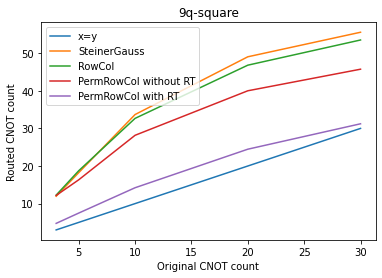

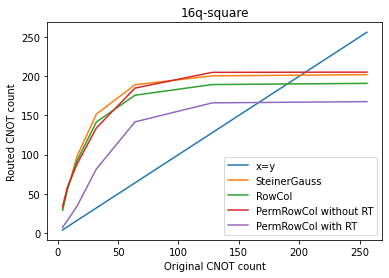

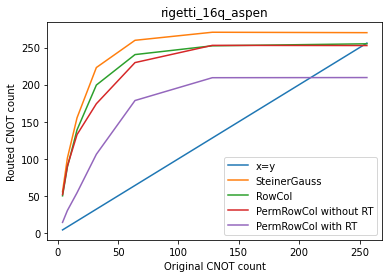

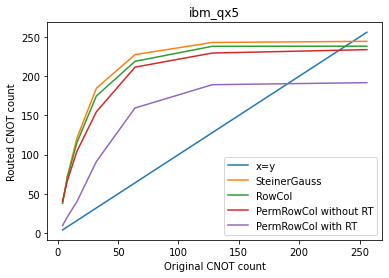

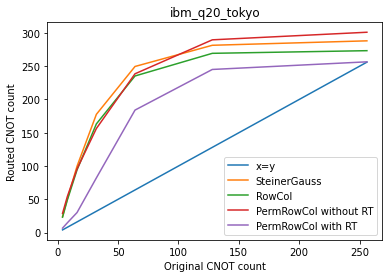

In [32]:
filename = "PermRowCol results.csv"
archs = [
    architecture.create_architecture(architecture.SQUARE, n_qubits=9),
    architecture.create_architecture(architecture.SQUARE, n_qubits=16),
    architecture.create_architecture(architecture.RIGETTI_16Q_ASPEN),
    architecture.create_architecture(architecture.IBM_QX5),
    architecture.create_architecture(architecture.IBM_Q20_TOKYO)
]
plot_results(filename, archs)

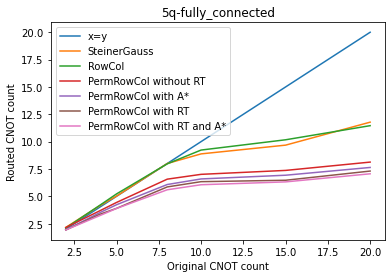

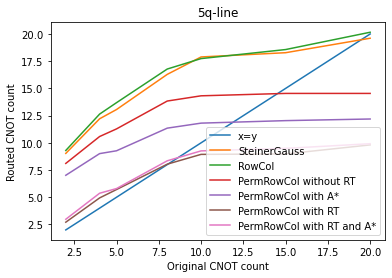

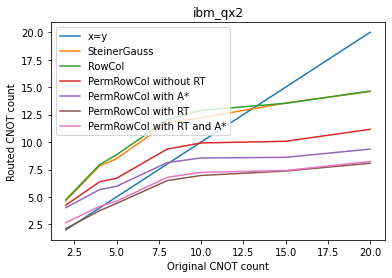

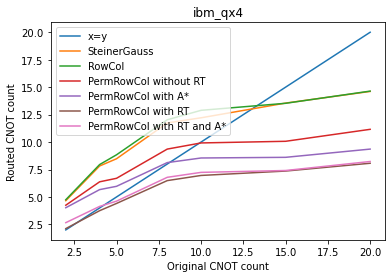

In [33]:
filename = "A* PermRowCol results.csv"
archs = [
    architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=5),
    architecture.create_architecture(architecture.LINE, n_qubits=5),
    architecture.create_architecture(architecture.IBM_QX2),
    architecture.create_architecture(architecture.IBM_QX4)
]
plot_results(filename, archs, n=6)

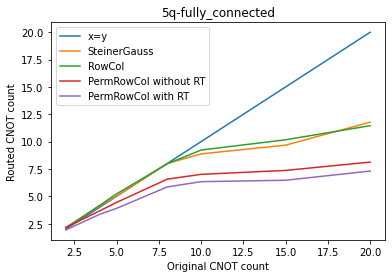

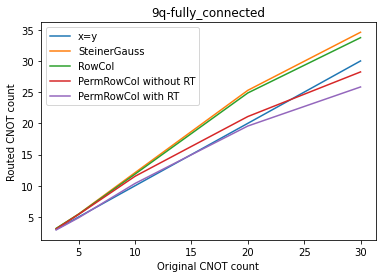

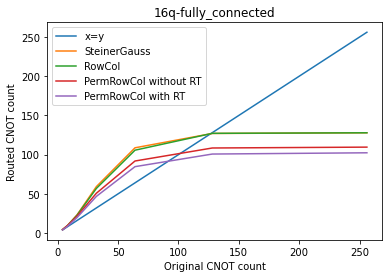

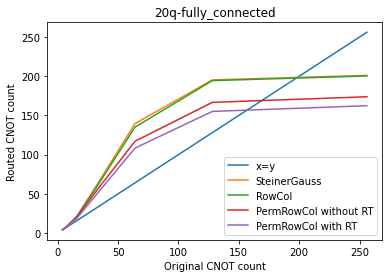

In [34]:
filename = "PermRowCol results UNCONSTRAINED.csv"
fully_connected_archs = [architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=n) for n in [5, 9, 16, 20]]
plot_results(filename, fully_connected_archs)